In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import matplotlib.pyplot as plt
import random

%matplotlib inline
print "Done"

Done


In [2]:
import smtplib
filename = "GradientDescentMomentum.txt"
def sendme_email():
    f = open(filename, 'r')
    body = f.read()
    body = ''.join(body) 
    print body
    
    # SMTP_SSL Example
    server_ssl = smtplib.SMTP_SSL("smtp.gmail.com", 465)
    server_ssl.ehlo() # optional, called by login()
    server_ssl.login("thalles753@gmail.com", "TyKo7E@b!?")  
    # ssl server doesn't support or need tls, so don't call server_ssl.starttls() 
    
    
    server_ssl.sendmail("thalles753@gmail.com", "thalles753@gmail.com", body)
    #server_ssl.quit()
    server_ssl.close()
    print 'successfully sent the mail'
    f.close()

In [3]:
def send_email(user, pwd, recipient, subject, body):

    gmail_user = user
    gmail_pwd = pwd
    FROM = user
    TO = recipient if type(recipient) is list else [recipient]
    SUBJECT = subject
    TEXT = body

    # Prepare actual message
    message = """From: %s\nTo: %s\nSubject: %s\n\n%s
    """ % (FROM, ", ".join(TO), SUBJECT, TEXT)
    try:
        server = smtplib.SMTP("smtp.gmail.com", 587)
        server.ehlo()
        server.starttls()
        server.login(gmail_user, gmail_pwd)
        server.sendmail(FROM, TO, message)
        server.close()
        print 'Successfully sent the mail'
    except:
        print "Failed to send mail"

In [4]:
def display_images_at_random(dataset, labels):
    # random.seed(1)
    
    f, axarr = plt.subplots(3, 3, figsize=(10,10))
    
    for i in range(3):
        for j in range(3):
            img_rand_index = random.randrange(0,dataset.shape[0])
            img  = dataset[img_rand_index]
            axarr[i, j].imshow(img.reshape(img.shape[0],img.shape[1]), cmap=plt.cm.Greys);
            axarr[i, j].set_title('Label: ' + str(labels[img_rand_index]) + " ID: " + str(img_rand_index))

    plt.show()

In [5]:
train_dataset = np.load("train_dataset.npy")
train_labels = np.load("train_labels.npy")
train_dataset_n_digits = np.load("train_n_bboxes.npy")
print('Training set', train_dataset.shape, train_labels.shape, train_dataset_n_digits.shape)

('Training set', (235500, 64, 64, 1), (235500, 5), (235500,))


Display some of the images just to make sure everything is fine

In [6]:
BATCH_SIZE=64
IMAGE_SIZE=64
N_CHANNELS=1
NUM_LABELS=10
NUM_DIGITS=5
VALIDATION_EVAL_STEPS=400
MINIBATCH_EVAL_STEPS=100
SEED=987
LEARNING_RATE_DECAY_FACTOR = 0.1  # Learning rate decay factor.
INITIAL_LEARNING_RATE = 0.1       # Initial learning rate.

([<matplotlib.axis.XTick at 0x7f399d7e08d0>,
 <a list of 6 Text xticklabel objects>)

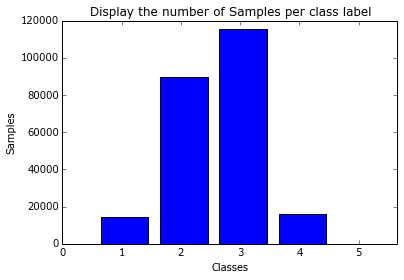

In [7]:
# distribution of sequences with 1,2,3,4 digits
data_distribution = np.bincount(train_dataset_n_digits)
index = np.arange(6)
plt.bar(index, data_distribution)
plt.title("Display the number of Samples per class label")
plt.xlabel('Classes')
plt.ylabel('Samples')

bar_width = 0.35
plt.xticks(index + bar_width, ('0', '1', '2', '3', '4', '5'))

In [8]:
print data_distribution
train_dataset_d1 = np.zeros(shape=(data_distribution[1], train_dataset.shape[1], train_dataset.shape[2], N_CHANNELS), dtype=np.float32)
train_dataset_d2 = np.zeros(shape=(data_distribution[2], train_dataset.shape[1], train_dataset.shape[2], N_CHANNELS), dtype=np.float32)
train_dataset_d3 = np.zeros(shape=(data_distribution[3], train_dataset.shape[1], train_dataset.shape[2], N_CHANNELS), dtype=np.float32)
train_dataset_d4 = np.zeros(shape=(data_distribution[4], train_dataset.shape[1], train_dataset.shape[2], N_CHANNELS), dtype=np.float32)

train_labels_d1 = np.zeros(shape=(data_distribution[1], NUM_DIGITS), dtype=np.float32)
train_labels_d2 = np.zeros(shape=(data_distribution[2], NUM_DIGITS), dtype=np.float32)
train_labels_d3 = np.zeros(shape=(data_distribution[3], NUM_DIGITS), dtype=np.float32)
train_labels_d4 = np.zeros(shape=(data_distribution[4], NUM_DIGITS), dtype=np.float32)

index_d1 = 0
index_d2 = 0
index_d3 = 0
index_d4 = 0

for bbox_index in range(0,len(train_dataset_n_digits)):
    bbox = train_dataset_n_digits[bbox_index]
    if bbox == 1:
        train_dataset_d1[index_d1,:,:,:] = train_dataset[bbox_index,:,:,:]
        train_labels_d1[index_d1,:] = train_labels[bbox_index,:]
        index_d1 += 1
    elif bbox == 2:
        train_dataset_d2[index_d2,:,:,:] = train_dataset[bbox_index,:,:,:]
        train_labels_d2[index_d2,:] = train_labels[bbox_index,:]
        index_d2 += 1
    elif bbox == 3:
        train_dataset_d3[index_d3,:,:,:] = train_dataset[bbox_index,:,:,:]
        train_labels_d3[index_d3,:] = train_labels[bbox_index,:]
        index_d3 += 1
    elif bbox == 4:
        train_dataset_d4[index_d4,:,:,:] = train_dataset[bbox_index,:,:,:]
        train_labels_d4[index_d4,:] = train_labels[bbox_index,:]
        index_d4 += 1

[     0  14512  89766 115338  15760    124]


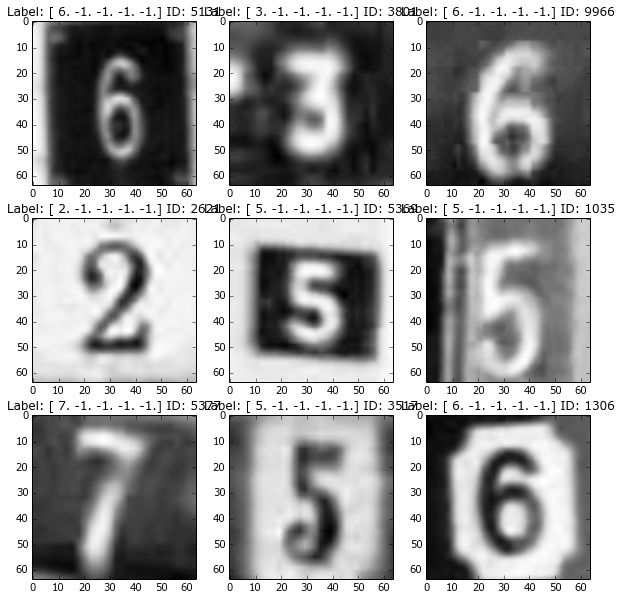

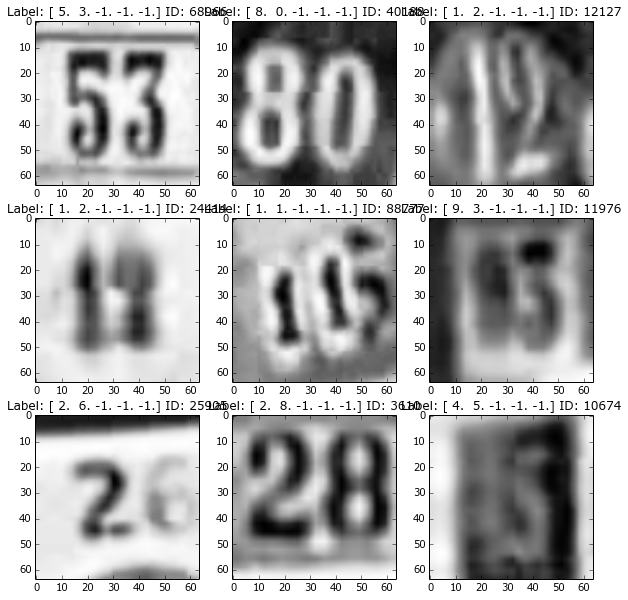

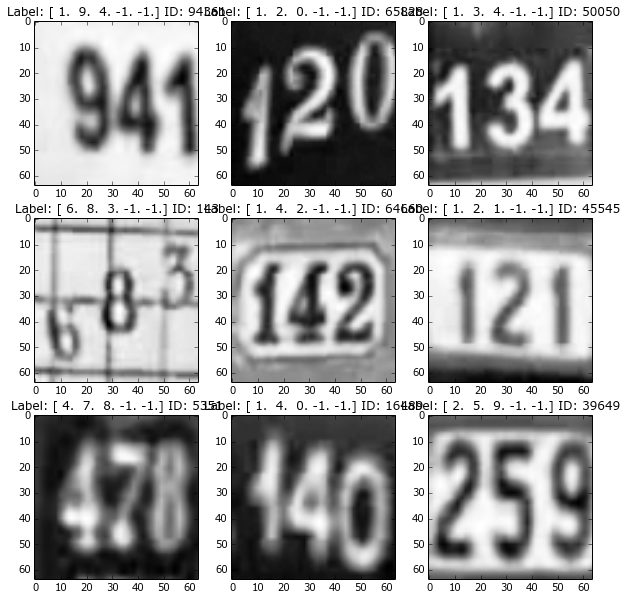

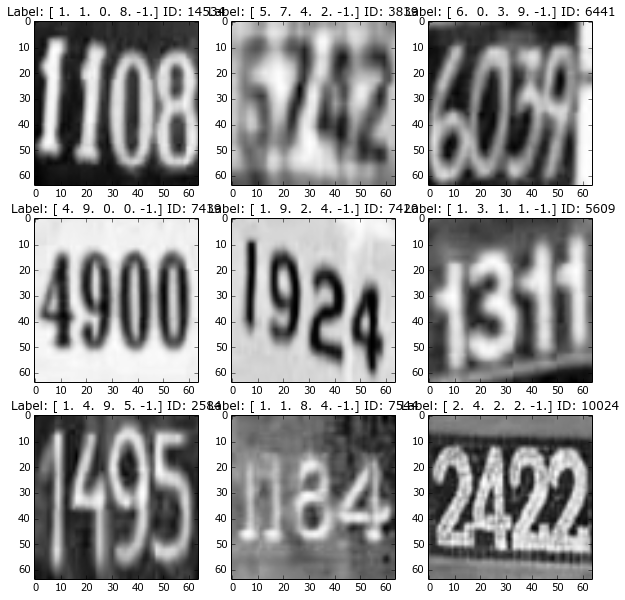

In [9]:
display_images_at_random(train_dataset_d1, train_labels_d1)
display_images_at_random(train_dataset_d2, train_labels_d2)
display_images_at_random(train_dataset_d3, train_labels_d3)
display_images_at_random(train_dataset_d4, train_labels_d4)

Compute the digit distribution for the first digit in each training image.

[  623 65535 45761 31896 24822 19412 14446 13823 10109  9073]
('Total dataset size:', 235500)


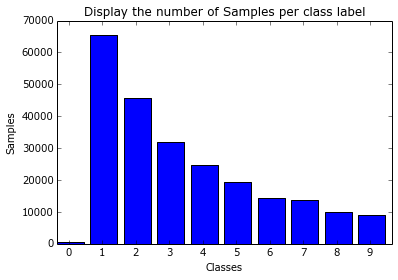

In [10]:
batch_d1 = []
NUM_CLASSES=10
which_digit = 0
add_error_class = False
for digit in train_labels:
    if digit[which_digit] == -1:
        batch_d1.append(10)
        add_error_class = True
    else:
        batch_d1.append(digit[which_digit])
 
if add_error_class:
    NUM_CLASSES+=1

data_distribution = np.bincount(batch_d1)
print data_distribution
index = np.arange(NUM_CLASSES)
plt.bar(index, data_distribution)
plt.title("Display the number of Samples per class label")
plt.xlabel('Classes')
plt.ylabel('Samples')

bar_width = 0.35
plt.xticks(index + bar_width, ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'))

print ("Total dataset size:", np.sum(data_distribution))
plt.show()

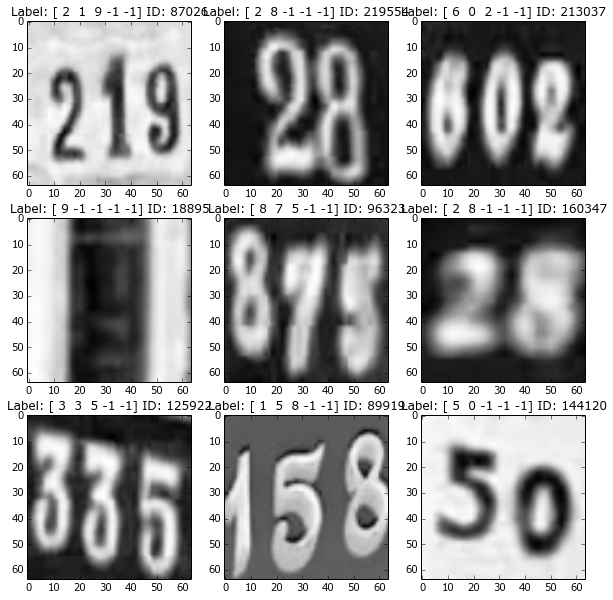

In [11]:
display_images_at_random(train_dataset, train_labels)

In [12]:
def reformat(train_labels):
    # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
    index = 0
    train_labels_one_hot = np.zeros(shape=(train_labels.shape[0], 5, 10), dtype=np.float32)
    for labels in train_labels:
        for l in labels:
            one_hot_array = (np.arange(NUM_LABELS) == labels[:,None]).astype(np.float32)
        train_labels_one_hot[index] = one_hot_array
        index += 1

    return train_labels_one_hot

# train_labels = reformat(train_labels)
train_labels_d1 = reformat(train_labels_d1)
train_labels_d2 = reformat(train_labels_d2)
train_labels_d3 = reformat(train_labels_d3)
train_labels_d4 = reformat(train_labels_d4)

In [13]:
print('Train set', train_dataset.shape, train_labels.shape)
print('Train set (D1)', train_dataset_d1.shape, train_labels_d1.shape)
print('Train set (D2)', train_dataset_d2.shape, train_labels_d2.shape)
print('Train set (D3)', train_dataset_d3.shape, train_labels_d3.shape)
print('Train set (D4)', train_dataset_d4.shape, train_labels_d4.shape)

('Train set', (235500, 64, 64, 1), (235500, 5))
('Train set (D1)', (14512, 64, 64, 1), (14512, 5, 10))
('Train set (D2)', (89766, 64, 64, 1), (89766, 5, 10))
('Train set (D3)', (115338, 64, 64, 1), (115338, 5, 10))
('Train set (D4)', (15760, 64, 64, 1), (15760, 5, 10))


In [14]:
def reformat_N_digits(n_digits):
  # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
  n_digits = (np.arange(NUM_DIGITS) == n_digits[:,None]).astype(np.float32)
  return n_digits

In [15]:
train_dataset_n_digits = np.array(train_dataset_n_digits)
train_dataset_n_digits = reformat_N_digits(train_dataset_n_digits)

In [16]:
print train_dataset_n_digits.shape

(235500, 5)


[ 7  1 -1 -1 -1]
[ 1  3  9 -1 -1]


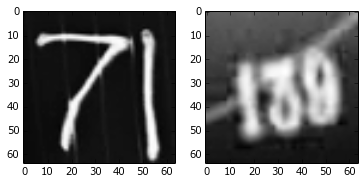

In [17]:
_, (ax1, ax2) = plt.subplots(1, 2)

id = 33402
img = train_dataset[id,:,:]
ax1.imshow(img.reshape(img.shape[0],img.shape[1]), cmap=plt.cm.Greys);
print train_labels[id]

id = 34662
img = train_dataset[id,:,:]
ax2.imshow(img.reshape(img.shape[0],img.shape[1]), cmap=plt.cm.Greys);
print train_labels[id]

In [18]:
VALIDATION_DATASET_SIZE=5000
TEST_DATASET_SIZE=20000

VALIDATION_SIZE_D1 = int(train_dataset_d1.shape[0] * 0.25)
VALIDATION_SIZE_D2 = int(train_dataset_d2.shape[0] * 0.05)
VALIDATION_SIZE_D3 = int(train_dataset_d3.shape[0] * 0.05)
VALIDATION_SIZE_D4 = int(train_dataset_d4.shape[0] * 0.25)

valid_dataset_d1 = train_dataset_d1[0:VALIDATION_SIZE_D1]
valid_dataset_d2 = train_dataset_d2[0:VALIDATION_SIZE_D2]
valid_dataset_d3 = train_dataset_d3[0:VALIDATION_SIZE_D3]
valid_dataset_d4 = train_dataset_d4[0:VALIDATION_SIZE_D4]

valid_labels_d1 = train_labels_d1[0:VALIDATION_SIZE_D1]
valid_labels_d2 = train_labels_d2[0:VALIDATION_SIZE_D2]
valid_labels_d3 = train_labels_d3[0:VALIDATION_SIZE_D3]
valid_labels_d4 = train_labels_d4[0:VALIDATION_SIZE_D4]

train_dataset_d1 = train_dataset_d1[VALIDATION_SIZE_D1:]
train_dataset_d2 = train_dataset_d2[VALIDATION_SIZE_D2:]
train_dataset_d3 = train_dataset_d3[VALIDATION_SIZE_D3:]
train_dataset_d4 = train_dataset_d4[VALIDATION_SIZE_D4:]

train_labels_d1 = train_labels_d1[VALIDATION_SIZE_D1:]
train_labels_d2 = train_labels_d2[VALIDATION_SIZE_D2:]
train_labels_d3 = train_labels_d3[VALIDATION_SIZE_D3:]
train_labels_d4 = train_labels_d4[VALIDATION_SIZE_D4:]

In [19]:
print('Training set (d1)', train_dataset_d1.shape, train_labels_d1.shape)
print('Training set (d2)', train_dataset_d2.shape, train_labels_d2.shape)
print('Training set (d3)', train_dataset_d3.shape, train_labels_d3.shape)
print('Training set (d4)', train_dataset_d4.shape, train_labels_d4.shape)

print('Validation set (d1)', valid_dataset_d1.shape, valid_labels_d1.shape)
print('Validation set (d2)', valid_dataset_d2.shape, valid_labels_d2.shape)
print('Validation set (d3)', valid_dataset_d3.shape, valid_labels_d3.shape)
print('Validation set (d4)', valid_dataset_d4.shape, valid_labels_d4.shape)
# print('Test set', test_dataset.shape, test_labels.shape)

('Training set (d1)', (10884, 64, 64, 1), (10884, 5, 10))
('Training set (d2)', (85278, 64, 64, 1), (85278, 5, 10))
('Training set (d3)', (109572, 64, 64, 1), (109572, 5, 10))
('Training set (d4)', (11820, 64, 64, 1), (11820, 5, 10))
('Validation set (d1)', (3628, 64, 64, 1), (3628, 5, 10))
('Validation set (d2)', (4488, 64, 64, 1), (4488, 5, 10))
('Validation set (d3)', (5766, 64, 64, 1), (5766, 5, 10))
('Validation set (d4)', (3940, 64, 64, 1), (3940, 5, 10))


In [20]:
imput_batch_images = tf.placeholder(tf.float32, shape=[None, IMAGE_SIZE, IMAGE_SIZE, N_CHANNELS], name="train_dataset_planceholder")

# Randomly crop a [height, width] section of the image.
x = tf.random_crop(imput_batch_images, [BATCH_SIZE, 56, 56, N_CHANNELS])

y_d1_ = tf.placeholder(tf.float32, shape=[BATCH_SIZE, NUM_LABELS], name="train_labels_d1_placeholder")
y_d2_ = tf.placeholder(tf.float32, shape=[BATCH_SIZE, NUM_LABELS], name="train_labels_d2_placeholder")
y_d3_ = tf.placeholder(tf.float32, shape=[BATCH_SIZE, NUM_LABELS], name="train_labels_d3_placeholder")
y_d4_ = tf.placeholder(tf.float32, shape=[BATCH_SIZE, NUM_LABELS], name="train_labels_d4_placeholder")

input_test_images = tf.placeholder(tf.float32, shape=[None, IMAGE_SIZE, IMAGE_SIZE, N_CHANNELS], name="test_images_placeholder")
tf_valid_dataset = tf.image.resize_images(input_test_images, 56, 56, method=0, align_corners=False)

d2 = tf.placeholder(tf.bool, name="is_2_digit_image_placeholder")
d3 = tf.placeholder(tf.bool, name="is_3_digit_image_placeholder")
d4 = tf.placeholder(tf.bool, name="is_4_digit_image_placeholder")

In [21]:
def weight_variable(shape, stddev=1e-1):
  initial = tf.truncated_normal(shape, stddev=stddev,seed=SEED)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(value=0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x, strides=[1, 2, 2, 1]):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=strides, padding='SAME')

print "Done"

Done


In [22]:
CONV1_DEPTH=16
W_conv1 = weight_variable([5, 5, N_CHANNELS, CONV1_DEPTH], stddev=0.1)
b_conv1 = bias_variable([CONV1_DEPTH])

CONV2_DEPTH=32
W_conv2 = weight_variable([5, 5, CONV1_DEPTH, CONV2_DEPTH], stddev=0.1)
b_conv2 = bias_variable([CONV2_DEPTH])

CONV3_DEPTH=48
W_conv3 = weight_variable([5, 5, CONV2_DEPTH, CONV3_DEPTH], stddev=0.09)
b_conv3 = bias_variable([CONV3_DEPTH])

CONV4_DEPTH=32
W_conv4 = weight_variable([5, 5, CONV3_DEPTH, CONV4_DEPTH], stddev=0.08)
b_conv4 = bias_variable([CONV4_DEPTH])

CONV5_DEPTH=64
W_conv5 = weight_variable([5, 5, CONV4_DEPTH, CONV5_DEPTH], stddev=0.05)
b_conv5 = bias_variable([CONV5_DEPTH])

CONV6_DEPTH=80
W_conv6 = weight_variable([5, 5, CONV5_DEPTH, CONV6_DEPTH], stddev=0.05)
b_conv6 = bias_variable([CONV6_DEPTH])

CONV7_DEPTH=96
W_conv7 = weight_variable([5, 5, CONV6_DEPTH, CONV7_DEPTH], stddev=0.03)
b_conv7 = bias_variable([CONV7_DEPTH])

FC1_SIZE = 256
W_fc1 = weight_variable([4 * 4 * CONV7_DEPTH, FC1_SIZE], stddev=0.05)
b_fc1 = bias_variable([FC1_SIZE])

FC2_SIZE = 256
W_fc2 = weight_variable([FC1_SIZE, FC2_SIZE], stddev=0.05)
b_fc2 = bias_variable([FC2_SIZE])

FC3_SIZE = 2048
W_fc3 = weight_variable([FC2_SIZE, FC3_SIZE], stddev=0.003)
b_fc3 = bias_variable([FC3_SIZE])

read_output_layer_digit_1 = weight_variable([FC3_SIZE, NUM_LABELS])
read_output_bias_digit_1 = bias_variable([NUM_LABELS])

read_output_layer_digit_2 = weight_variable([FC3_SIZE, NUM_LABELS])
read_output_bias_digit_2 = bias_variable([NUM_LABELS])

read_output_layer_digit_3 = weight_variable([FC3_SIZE, NUM_LABELS])
read_output_bias_digit_3 = bias_variable([NUM_LABELS])

read_output_layer_digit_4 = weight_variable([FC3_SIZE, NUM_LABELS])
read_output_bias_digit_4 = bias_variable([NUM_LABELS])

print "Done"

Done


In [23]:
def model(x_image, training=False):

    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)
    norm1 = tf.nn.lrn(h_pool1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm1')
    # print norm1
    
    h_conv2 = tf.nn.relu(conv2d(norm1, W_conv2) + b_conv2)
    norm2 = tf.nn.lrn(h_conv2, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm2')
    h_pool2 = max_pool_2x2(norm2, strides=[1,1,1,1])
    # print h_pool2
    
    h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
    h_pool3 = max_pool_2x2(h_conv3)
    norm3 = tf.nn.lrn(h_pool3, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm3')
    # print norm3
    
    h_conv4 = tf.nn.relu(conv2d(norm3, W_conv4) + b_conv4)
    norm4 = tf.nn.lrn(h_conv4, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm4')
    h_pool4 = max_pool_2x2(norm4, strides=[1,1,1,1])
    # print h_pool4
    
    h_conv5 = tf.nn.relu(conv2d(h_pool4, W_conv5) + b_conv5)
    h_pool5 = max_pool_2x2(h_conv5)
    norm5 = tf.nn.lrn(h_pool5, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm5')
    # print norm5
    
    h_conv6 = tf.nn.relu(conv2d(norm5, W_conv6) + b_conv6)
    norm6 = tf.nn.lrn(h_conv6, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm6')
    h_pool6 = max_pool_2x2(norm6, strides=[1,1,1,1])

    h_conv7 = tf.nn.relu(conv2d(h_pool6, W_conv7) + b_conv7)
    h_pool7 = max_pool_2x2(h_conv7)
    norm7 = tf.nn.lrn(h_pool7, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm7')
    
    shape = norm7.get_shape().as_list()
    h_pool_flat = tf.reshape(norm7, [-1, shape[1] * shape[2] * shape[3]])

    # First fully connected layer
    h_fc1 = tf.nn.relu(tf.matmul(h_pool_flat, W_fc1) + b_fc1)
    if (training == True):
        h_fc1 = tf.nn.dropout(h_fc1, 0.5, seed=SEED)

    # Second fully connected layer
    h_fc2 = tf.nn.relu(tf.matmul(h_fc1, W_fc2) + b_fc2)
    if (training == True):
        h_fc2 = tf.nn.dropout(h_fc2, 0.5, seed=SEED)

    # Third fully connected layer
    h_fc3 = tf.nn.relu(tf.matmul(h_fc2, W_fc3) + b_fc3)
    if (training == True):
        h_fc3 = tf.nn.dropout(h_fc3, 0.5, seed=SEED)

    # digit #1
    digit_1 = tf.matmul(h_fc3, read_output_layer_digit_1) + read_output_bias_digit_1

    blank_digit = lambda: tf.zeros(shape=[64,10], dtype=tf.float32, name="Blank_digit")

    # digit #2
    f2 = lambda: tf.matmul(h_fc3, read_output_layer_digit_2) + read_output_bias_digit_2
    digit_2 = tf.case([(d2, f2)], default=blank_digit)
    
    # digit #3
    f3 = lambda: tf.matmul(h_fc3, read_output_layer_digit_3) + read_output_bias_digit_3
    digit_3 = tf.case([(d3, f3)], default=blank_digit)

    # digit #4
    f4 = lambda: tf.matmul(h_fc3, read_output_layer_digit_4) + read_output_bias_digit_4
    digit_4 = tf.case([(d4, f4)], default=blank_digit)

    return digit_1, digit_2, digit_3, digit_4

print "Done"

Done


In [ ]:
# logits = model(x, True)
logits_d1, logits_d2, logits_d3, logits_d4 = model(x, True)

loss_d1 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits_d1, y_d1_))
loss_d2 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits_d2, y_d2_))
loss_d3 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits_d3, y_d3_))
loss_d4 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits_d4, y_d4_))

# apply L2 regularization of the trained weights
regularizers = (tf.nn.l2_loss(W_fc1) + tf.nn.l2_loss(b_fc1) +
                tf.nn.l2_loss(W_fc2) + tf.nn.l2_loss(b_fc2) +
                tf.nn.l2_loss(W_fc3) + tf.nn.l2_loss(b_fc3))

a1 = tf.Print(loss_d1, [loss_d1], message="Loss d1 is: ")
a2 = tf.Print(loss_d2, [loss_d2], message="Loss d2 is: ")
a3 = tf.Print(loss_d3, [loss_d3], message="Loss d3 is: ")
a4 = tf.Print(loss_d4, [loss_d4], message="Loss d4 is: ")

total_loss = loss_d1
total_loss += tf.case([(d2, lambda: loss_d2)], default = lambda: tf.zeros([1]))
total_loss += tf.case([(d3, lambda: loss_d3)], default = lambda: tf.zeros([1]))
total_loss += tf.case([(d4, lambda: loss_d4)], default = lambda: tf.zeros([1]))

total_loss += 5e-4 * regularizers

loss_summary = tf.scalar_summary('loss digit 1', loss_d1)

# Create a variable to track the global step.
global_step = tf.Variable(0, name='global_step', trainable=False)

starter_learning_rate = 0.001
learning_rate = tf.train.exponential_decay(starter_learning_rate,
                                           global_step * BATCH_SIZE,
                                           train_labels.shape[0] / 8,
                                           0.99,
                                           staircase=True)

# learning_rate_summary = tf.scalar_summary('learning_rate', learning_rate)

momentum = 0.95
optimizer_d1 = tf.train.MomentumOptimizer(learning_rate, momentum, use_locking=False).minimize(total_loss, global_step=global_step)

# Predictions for the minibatch, validation set and test set.
train_pred_d1 = tf.nn.softmax(logits_d1)
train_pred_d2 = tf.nn.softmax(logits_d2)
train_pred_d3 = tf.nn.softmax(logits_d3)
train_pred_d4 = tf.nn.softmax(logits_d4)

# valid_logits = model(tf_valid_dataset, False)
# valid_logits, valid_logits_n_digits = model(tf_valid_dataset, False)
valid_logits_d1, valid_logits_d2, valid_logits_d3, valid_logits_d4 = model(tf_valid_dataset, False)
valid_pred_d1 = tf.nn.softmax(valid_logits_d1)
valid_pred_d2 = tf.nn.softmax(valid_logits_d2)
valid_pred_d3 = tf.nn.softmax(valid_logits_d3)
valid_pred_d4 = tf.nn.softmax(valid_logits_d4)

print "Done"

Done


In [ ]:
# Create a new interactive session that we'll use in
# subsequent code cells.
s = tf.InteractiveSession()

# Use our newly created session as the default for 
# subsequent operations.
s.as_default()

# Merge all the summaries and write them out to /tmp/mnist_logs (by default)
# merged = tf.merge_summary([loss_summary, learning_rate_summary])
# train_writer = tf.train.SummaryWriter('./summary', s.graph)

# Initialize all the variables we defined above.
init = tf.initialize_all_variables()

# Add ops to save and restore all the variables.
saver = tf.train.Saver()

s.run(init)

In [ ]:
def error_rate(predictions, labels):
  """Return the error rate and confusions."""
  correct = np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
  total = predictions.shape[0]

  error = 100.0 - (100 * float(correct) / float(total))

  confusions = np.zeros([10, 10], np.float32)
  bundled = zip(np.argmax(predictions, 1), np.argmax(labels, 1))
  for predicted, actual in bundled:
    confusions[predicted, actual] += 1
    
  return error, confusions

print 'Done'

In [ ]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [ ]:
def compute_per_digit_accuracy(predictions, labels, for_digit):
    index = 0
    batch = np.zeros(shape=(labels.shape[0],10), dtype=np.float32)
    for digit in labels:
        # print digit.shape
        batch[index] = digit[for_digit] # get s only the first digits of each image
        index += 1
        
    return accuracy(predictions, batch)

In [ ]:
def get_error_rate(predictions, labels):
    index = 0
    batch_d1 = np.zeros(shape=(labels.shape[0],10), dtype=np.float32)
    for digit in labels:
        # print digit.shape
        batch_d1[index] = digit[0] # get s only the first digits of each image
        index += 1
        
    return error_rate(predictions, batch_d1)

In [ ]:
def get_batch_data_and_labels(global_step, batch_size, train_data, train_labels):
    offset = (global_step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_data[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    return batch_data, batch_labels

In [ ]:
total_steps = 10000

for step in xrange(total_steps):

    labels_d1 = np.zeros(shape=(BATCH_SIZE, 10), dtype=np.float32)
    labels_d2 = np.zeros(shape=(BATCH_SIZE, 10), dtype=np.float32)
    labels_d3 = np.zeros(shape=(BATCH_SIZE, 10), dtype=np.float32)
    labels_d4 = np.zeros(shape=(BATCH_SIZE, 10), dtype=np.float32)

    for current_batch_digit in range(1,5):

        if current_batch_digit == 1:
            # generate batch dataset with images with only one digit on it
            batch_data_d1, batch_labels_d1 = get_batch_data_and_labels(step, BATCH_SIZE, train_dataset_d1, train_labels_d1)

            # gets only the digits #1 labels data
            index = 0
            for digit in batch_labels_d1:
                labels_d1[index] = digit[0]
                index += 1

            feed_dict = {imput_batch_images : batch_data_d1,
                         y_d1_ : labels_d1,
                         y_d2_ : labels_d2,
                         y_d3_ : labels_d3,
                         y_d4_ : labels_d4,
                         d2: False, d3: False, d4: False}

            # Run the graph and fetch some of the nodes.feed_dict=feed_dict)
            _, l1, l2, l3, l4, tot_loss, predictions_d1, gl = s.run([optimizer_d1, loss_d1, loss_d2, loss_d3, loss_d4, total_loss, train_pred_d1, global_step], feed_dict=feed_dict)
            # train_writer.add_summary(summary, step)
            
        elif current_batch_digit == 2:
            batch_data_d2, batch_labels_d2 = get_batch_data_and_labels(step, BATCH_SIZE, train_dataset_d2, train_labels_d2)

            index = 0
            for digit in batch_labels_d2:
                labels_d1[index] = digit[0]
                labels_d2[index] = digit[1]
                index += 1

            feed_dict = {imput_batch_images : batch_data_d2,
                         y_d1_ : labels_d1,
                         y_d2_ : labels_d2,
                         y_d3_ : labels_d3,
                         y_d4_ : labels_d4,
                         d2: True, d3: False, d4: False}

            # Run the graph and fetch some of the nodes.
            _, l1, l2, l3, l4, tot_loss, predictions_d1, predictions_d2, gl = s.run([
                    optimizer_d1, loss_d1 ,loss_d2, loss_d3, loss_d4,
                    total_loss,
                    train_pred_d1, train_pred_d2,
                    global_step], feed_dict=feed_dict)  
            
        elif current_batch_digit == 3:
            batch_data_d3, batch_labels_d3 = get_batch_data_and_labels(step, BATCH_SIZE, train_dataset_d3, train_labels_d3)

            index = 0
            for digit in batch_labels_d3:
                labels_d1[index] = digit[0]
                labels_d2[index] = digit[1]
                labels_d3[index] = digit[2]
                index += 1

            feed_dict = {imput_batch_images : batch_data_d3,
                         y_d1_ : labels_d1,
                         y_d2_ : labels_d2,
                         y_d3_ : labels_d3,
                         y_d4_ : labels_d4,
                         d2: True, d3: True, d4: False}

            # Run the graph and fetch some of the nodes.
            _, l1, l2, l3, l4, tot_loss, predictions_d1, predictions_d2, predictions_d3, gl = s.run([
                    optimizer_d1, loss_d1 ,loss_d2, loss_d3, loss_d4,
                    total_loss,
                    train_pred_d1, train_pred_d2, train_pred_d3,
                    global_step], feed_dict=feed_dict)
            
        elif current_batch_digit == 4:
            batch_data_d4, batch_labels_d4 = get_batch_data_and_labels(step, BATCH_SIZE, train_dataset_d4, train_labels_d4)

            index = 0
            for digit in batch_labels_d4:
                labels_d1[index] = digit[0]
                labels_d2[index] = digit[1]
                labels_d3[index] = digit[2]
                labels_d4[index] = digit[3]
                index += 1

            feed_dict = {imput_batch_images : batch_data_d4,
                         y_d1_ : labels_d1,
                         y_d2_ : labels_d2,
                         y_d3_ : labels_d3,
                         y_d4_ : labels_d4,
                         d2: True, d3: True, d4: True}

            # Run the graph and fetch some of the nodes.
            _, l1, l2, l3, l4, tot_loss, predictions_d1, predictions_d2, predictions_d3, predictions_d4, lr, gl = s.run([
                    optimizer_d1, loss_d1 ,loss_d2, loss_d3, loss_d4,
                    total_loss,
                    train_pred_d1, train_pred_d2, train_pred_d3, train_pred_d4,
                    learning_rate, global_step], feed_dict=feed_dict)
            
        if step % 100 == 0 and current_batch_digit == 4:
            print("Loss 1: %f\tLoss 2: %f\t Loss 3: %f\t Loss 4: %f" % (l1, l2, l3, l4))
            print("Total loss at step %d: %f\tLearning rate: %f" % (step, tot_loss, lr))
            print('Digit 1: Minibatch accuracy: %.1f%%' % accuracy(predictions_d1, labels_d1))
            if step % 300  == 0:
                print('Digit 1: Validation accuracy: %.1f%%' % compute_per_digit_accuracy(valid_pred_d1.eval({input_test_images: valid_dataset_d1, d2: False, d3: False, d4: False}), valid_labels_d1, 0))
                print"-------------------------------------------";
                
            print('Digit 2: Minibatch accuracy: %.1f%%' % accuracy(predictions_d2, labels_d2))
            if step % 300  == 0:
                print('Digit 2: Validation accuracy: %.1f%%' % compute_per_digit_accuracy(valid_pred_d2.eval({input_test_images: valid_dataset_d2, d2: True, d3: False, d4: False}), valid_labels_d2, 1))
                print"-------------------------------------------";
            
            print('Digit 3: Minibatch accuracy: %.1f%%' % accuracy(predictions_d3, labels_d3))
            if step % 300  == 0:
                print('Digit 3: Validation accuracy: %.1f%%' % compute_per_digit_accuracy(valid_pred_d3.eval({input_test_images: valid_dataset_d3, d2: True, d3: True, d4: False}), valid_labels_d3, 2))
                print"-------------------------------------------";
                
            print('Digit 4: Minibatch accuracy: %.1f%%' % accuracy(predictions_d4, labels_d4))
            if step % 300  == 0:
                print('Digit 4: Validation accuracy: %.1f%%' % compute_per_digit_accuracy(valid_pred_d4.eval({input_test_images: valid_dataset_d4, d2: True, d3: True, d4: True}), valid_labels_d4, 3))

            # print('N Digits: Minibatch loss at step %d: %f\tLearning rate:%f' % (gl, loss_n_dts, lr))
            # print('N Digits: Minibatch accuracy: %.1f%%' % accuracy(n_digits_predictions, batch_n_digits_labels))
            # if step % 500 == 0:
            #     print('N Digits: Validation accuracy: %.1f%%' % accuracy(valid_n_digits_prediction.eval(), valid_n_digits))
            print "=================================================="

print "Done training"

Resizing image	New shape: 43 64
(1, 64, 64, 1)
(1, 64, 64, 1)


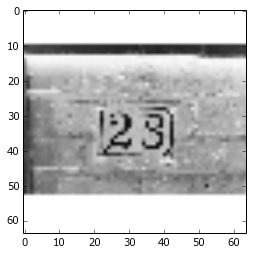

In [44]:
from scipy import misc
PIXEL_DEPTH=255.0

# display the first and the last image and labels for the training dataset
img = misc.imread("./image_test5.jpg", flatten=True)

# get the new image size
img_h = img.shape[0]
img_w = img.shape[1]

# if the image is greater than IMAGE_SIZE, slowly resize it
# until it fits the size
if img_h > IMAGE_SIZE or img_w > IMAGE_SIZE:
    if img_w >= img_h:
        target_width = IMAGE_SIZE
        target_height = int(round((img_h * IMAGE_SIZE) / float(img_w)))
    else:
        target_height = IMAGE_SIZE
        target_width = int(round((img_w * IMAGE_SIZE) / float(img_h)))

    if (target_width < 10 or target_height < 10):
        print "--- Discarding image \tShape:",target_height, target_width, "---"
        skipped_images_count += 1


    img = misc.imresize(img,(target_height, target_width))
    is_resized = True

if is_resized == True:
    print "Resizing image\tNew shape:",target_height, target_width

# get the new image size
img_h = img.shape[0]
img_w = img.shape[1]
# put the image to the defined size
if img_h < IMAGE_SIZE:
    top_padding = (IMAGE_SIZE-img_h)/2
    bottom_padding = IMAGE_SIZE-img_h - top_padding
    img = np.pad(img, ((top_padding,bottom_padding),(0,0)), "constant")

if img_w < IMAGE_SIZE:
    top_padding = (IMAGE_SIZE-img_w)/2
    bottom_padding = IMAGE_SIZE-img_w - top_padding
    img = np.pad(img, ((0,0),(top_padding,bottom_padding)), "constant")

# TODO: normalize the image
img = (img - (PIXEL_DEPTH / 2.0)) / PIXEL_DEPTH
img = img.reshape(1,IMAGE_SIZE,IMAGE_SIZE,N_CHANNELS)
print img.shape
plt.imshow(img[0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap=plt.cm.Greys)
print img.shape

In [45]:
pred1 = valid_pred_d1.eval({input_test_images: img, d2: False, d3: False})
pred2 = valid_pred_d2.eval({input_test_images: img, d2: True, d3: False})
pred3 = valid_pred_d3.eval({input_test_images: img, d2: False, d3: True})

print np.argmax(pred1, 1)
print np.argmax(pred2, 1)
print np.argmax(pred3, 1)

[1]
[4]
[0]


In [ ]:
test_error, confusions = get_error_rate(test_prediction.eval({tf_test_dataset: test_dataset}), test_labels)
print 'Test error: %.1f%%' % test_error

In [ ]:
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(False)
plt.xticks(np.arange(NUM_LABELS))
plt.yticks(np.arange(NUM_LABELS))
plt.imshow(confusions, cmap=plt.cm.jet, interpolation='nearest');

for i, cas in enumerate(confusions):
  for j, count in enumerate(cas):
    if count > 0:
      xoff = .07 * len(str(count))
      plt.text(j-xoff, i+.2, int(count), fontsize=9, color='white')
print 'Done'

In [ ]:
import scipy.misc as misc
import numpy as np

IMAGE_SIZE=56
N_CHANNELS=1
MAX_NUMBER_OF_SEGMENTATIONS=8

img_file_name = "image_test3.jpg"

original = misc.imread(img_file_name)
img = misc.imread(img_file_name,flatten=True)
img = misc.imresize(img, (IMAGE_SIZE,IMAGE_SIZE), interp='bilinear', mode=None)
print img.shape

PIXEL_DEPTH=255

test_image = np.zeros(shape=(1, IMAGE_SIZE, IMAGE_SIZE, N_CHANNELS), dtype=np.float32)

# normilize it
img = (img - (PIXEL_DEPTH / 2.0)) / PIXEL_DEPTH # normilize
test_image[0] = img.reshape(IMAGE_SIZE,IMAGE_SIZE,N_CHANNELS)

_, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(img, cmap=plt.cm.Greys);
ax1.set_title('Transformed')

ax2.imshow(original, cmap=plt.cm.Greys);
ax2.set_title('Original')

In [32]:
prediction = test_prediction.eval({tf_test_dataset: test_image})

In [33]:
print prediction
print np.argmax(prediction, 1)

[[  1.74425550e-05   3.49438437e-06   9.56964910e-01   1.90533570e-03
    3.15620936e-03   2.64062226e-04   3.30781448e-03   1.30507206e-05
    3.33615690e-02   1.00600568e-03]]
[2]
